# This notebook produces summary Heatmap plots for the cross-cell-line and seeding-density evaluation results for the wGAN gp prototype training

In [1]:
import pathlib

import pandas as pd
import matplotlib.pylab as plt
import PyComplexHeatmap as pch

## Evaluation directory

In [2]:
EVALUATION_DIR = pathlib.Path('.').absolute() / 'evaluation'
ALL_METRICS_FILE = EVALUATION_DIR / "all_metrics.csv"

assert ALL_METRICS_FILE.exists(), f"File {ALL_METRICS_FILE} does not exist"

PLOT_SAVE_DIR = EVALUATION_DIR / "summary_plots"
PLOT_SAVE_DIR.mkdir(exist_ok=True)

## Load metrics generated from 2.0.2

In [3]:
all_metrics_df = pd.read_csv(ALL_METRICS_FILE)
all_metrics_df['confluence'] = all_metrics_df['run_name'].str.extract(r'wGAN_gp_prototype_train_(.+?)_confluence_.+')
all_metrics_df['platemap_file'] = all_metrics_df['platemap_file'].apply(lambda x: 'Plate1' if 'Plate1' in x else 'Plate2')
all_metrics_df.head()

,PSNR,SSIM,MSELoss,L1Loss,LPIPS,DISTS,datasplit,cell_line,seeding_density,platemap_file,...,params.gen_optim_weight_decay,params.gen_optim_beta1,params.gen_optim_lr,params.gen_depth,params.disc_optim_beta0,params.disc_depth,params.disc_optim_weight_decay,params.confluence,params.channel_name,confluence_group
0,40.202316,0.594707,0.000095,0.008643,0.030524,0.251278,evaluation,A673,1000,Plate1,...,0,0.9,0.0002,4,0.0,4,0.001,high,OrigAGP,high
1,33.256210,0.333096,0.000472,0.011995,0.074666,0.288461,evaluation,A673,1000,Plate1,...,0,0.9,0.0002,4,0.0,4,0.001,high,OrigAGP,high
2,37.051292,0.484929,0.000197,0.010136,0.018950,0.225079,evaluation,A673,1000,Plate1,...,0,0.9,0.0002,4,0.0,4,0.001,high,OrigAGP,high
3,39.599640,0.524679,0.000110,0.010241,0.024285,0.195178,evaluation,A673,1000,Plate1,...,0,0.9,0.0002,4,0.0,4,0.001,high,OrigAGP,high
4,37.275726,0.498827,0.000187,0.009823,0.022561,0.227211,evaluation,A673,1000,Plate1,...,0,0.9,0.0002,4,0.0,4,0.001,high,OrigAGP,high


## Define Helper functions

In [4]:
## Aggregate a single metric into a matrix that is (cell-line + platemap) by (channel + seeding-density)
def prepare_metric_aggr_anno(df, metric_name):
    # Identify duplicated cell lines
    cell_line_counts = df.groupby('cell_line')['platemap_file'].nunique()
    duplicated_cell_lines = cell_line_counts[cell_line_counts > 1].index

    # Create a mapping for abbreviated indices
    cell_line_mapping = {}
    for cell_line in duplicated_cell_lines:
        platemap_instances = df.loc[df['cell_line'] == cell_line, 'platemap_file'].unique()
        for i, platemap in enumerate(sorted(platemap_instances), start=1):
            cell_line_mapping[(cell_line, platemap)] = f"{cell_line} ({i})"

    # Perform aggregation: mean values grouped by the combined keys
    agg_df = df.groupby(
        ['cell_line', 'platemap_file', 'seeding_density', 'params.channel_name']
    )[metric_name].mean().reset_index()

    # Create a new column that combines 'seeding_density' and 'params.channel_name' for proper column formatting
    agg_df['channel_density'] = agg_df['params.channel_name'] + "-" + agg_df['seeding_density'].astype(str)

    # Apply the mapping to create a modified index
    agg_df['modified_index'] = agg_df.apply(
        lambda row: cell_line_mapping.get((row['cell_line'], row['platemap_file']), row['cell_line']), axis=1
    )

    # Pivot table with the new modified index
    pivot_df = agg_df.pivot(
        index='modified_index',
        columns='channel_density',
        values=metric_name
    )

    # Ensure columns are sorted by 'channel_name' groups and 'seeding_density' in ascending order
    sorted_columns = sorted(
        pivot_df.columns,
        key=lambda x: (x.split('-')[0], int(x.split('-')[1]))  # Sort by channel_name first, then seeding_density numerically
    )
    pivot_df = pivot_df[sorted_columns]

    ## Row annotation
    row_annotation_df = df.groupby(['cell_line', 'platemap_file'])[['datasplit']].first().reset_index()
    # Apply the same abbreviation logic as used in pivot_df
    row_annotation_df['modified_index'] = row_annotation_df.apply(
        lambda row: cell_line_mapping.get((row['cell_line'], row['platemap_file']), row['cell_line']), axis=1
    )
    # Set the new abbreviated index
    row_annotation_df.set_index('modified_index', inplace=True)
    # Rename columns for clarity
    row_annotation_df.rename(columns={'platemap_file': 'platemap'}, inplace=True)
    # Ensure the order matches pivot_df
    row_annotation_df = row_annotation_df.reindex(pivot_df.index)

    ## Column annotation
    column_annotation_df = agg_df[['channel_density', 'params.channel_name', 'seeding_density']].drop_duplicates().set_index('channel_density')
    column_annotation_df.rename(columns={'params.channel_name': 'channel', 'seeding_density': 'seeding_density'}, inplace=True)
    column_annotation_df = column_annotation_df.reindex(pivot_df.columns)

    return pivot_df, row_annotation_df, column_annotation_df

## Plot the heatmap with PyComplexHeatmap
def plot_metric_heatmap(
        pivot_df, 
        row_annotation_df=None, 
        column_annotation_df=None, 
        title="",
        metric_name="metric",
        save_path=None,
        sns_kwargs=None
        ):
    plt.figure(figsize=(10, 5))
    plt.title(title)

    if row_annotation_df is None:
        row_ha = None
    else:
        row_ha = pch.HeatmapAnnotation(
            Datasplit=pch.anno_simple(
                row_annotation_df.datasplit, 
                add_text=False, 
                legend=True, 
                cmap='nature3_1',
                ),
            Platemap=pch.anno_simple(
                row_annotation_df.platemap, 
                add_text=True, 
                legend=False, 
                cmap='nature3_3'),
            axis=0,
            legend=True, legend_gap=5, hgap=0.5
        )

    if column_annotation_df is None:
        col_ha = None
    else:
        col_ha = pch.HeatmapAnnotation(
            SeedingDensity=pch.anno_simple(
                column_annotation_df.seeding_density, 
                add_text=False, 
                legend=True, 
                cmap='Reds'),
            Channel=pch.anno_simple(
                column_annotation_df.channel, 
                add_text=True, 
                legend=False),
            legend=True, legend_gap=5, hgap=0.5
        )

    hm = pch.ClusterMapPlotter(
        data=pivot_df,
        left_annotation=row_ha,
        bottom_annotation=col_ha,
        col_cluster=False, row_cluster=False,
        row_split=row_annotation_df.platemap,
        row_split_gap=1.0,
        col_split=column_annotation_df.channel,
        col_split_gap=1.0,
        label=metric_name,
        xlabel='Seeding Density',
        ylabel='Cell Line',
        show_colnames=False, show_rownames=True,
        cmap='viridis',
        plot=True,
        **sns_kwargs
    )

    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')

    plt.show()

    return hm

## Plot Summary Heatmaps

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 25.930555555555557 mm


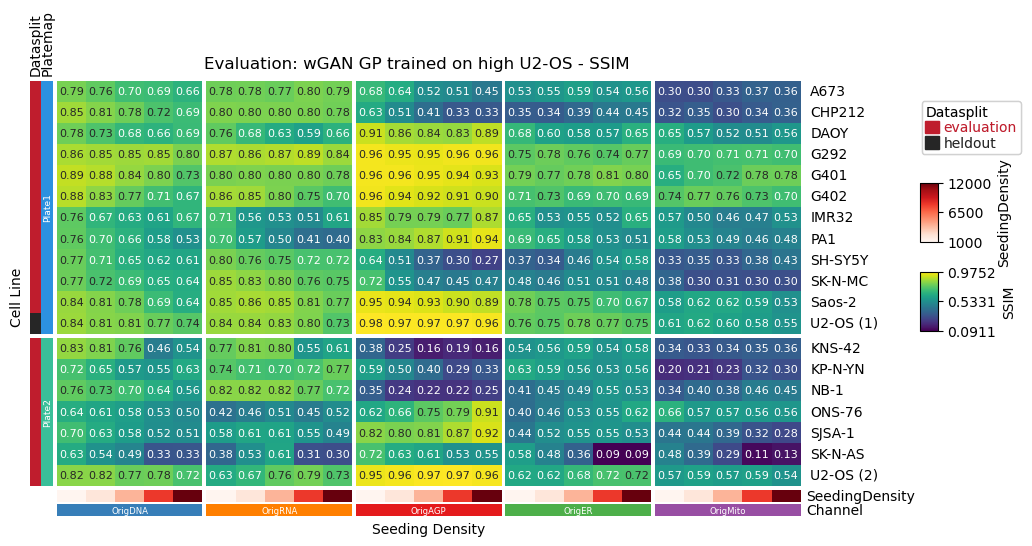

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 25.930555555555557 mm


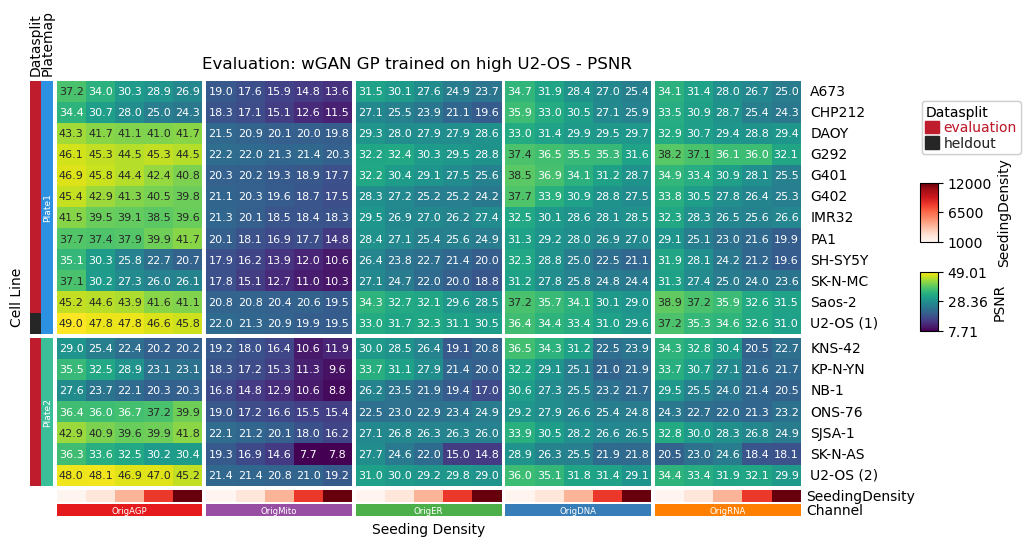

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 25.930555555555557 mm


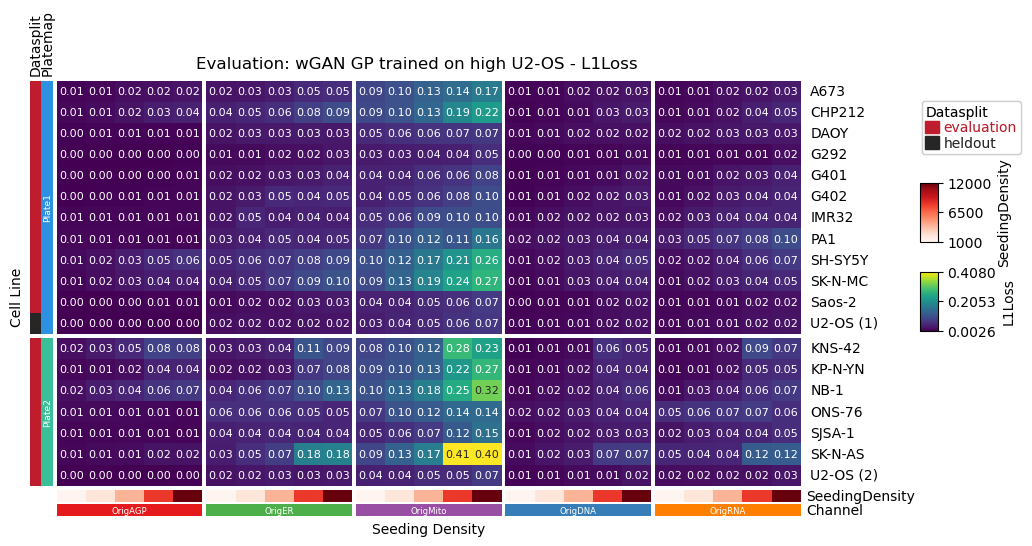

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 25.930555555555557 mm


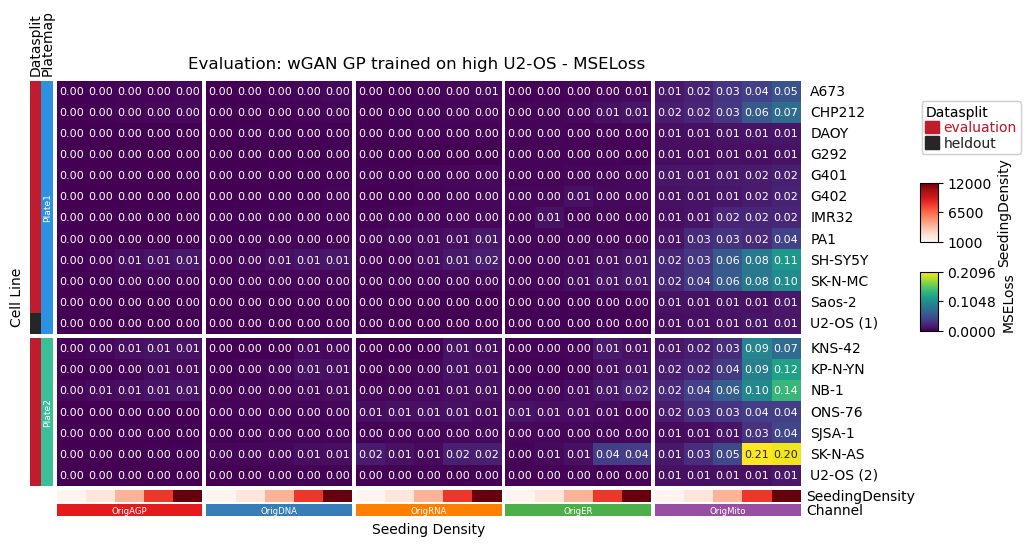

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 25.930555555555557 mm


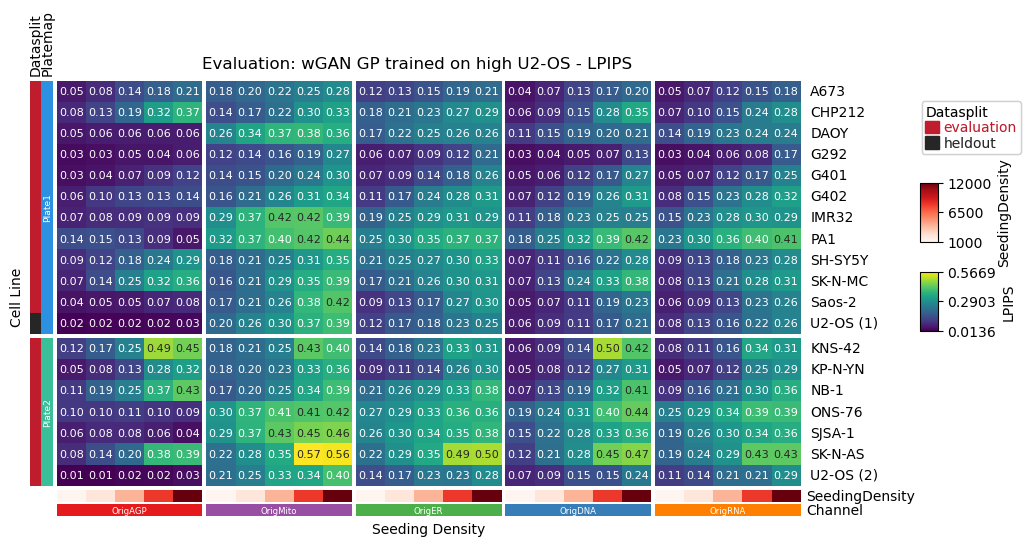

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 25.930555555555557 mm


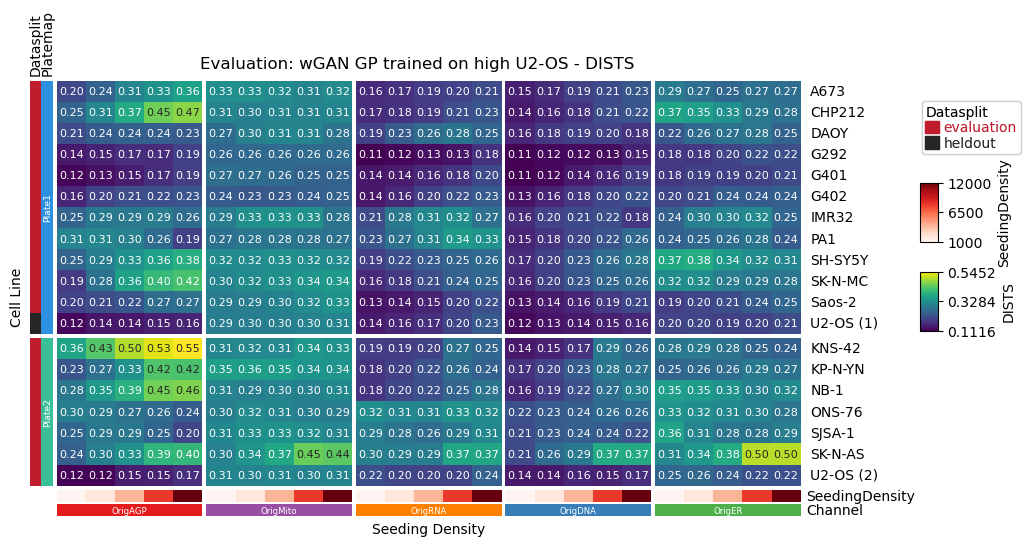

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 25.930555555555557 mm


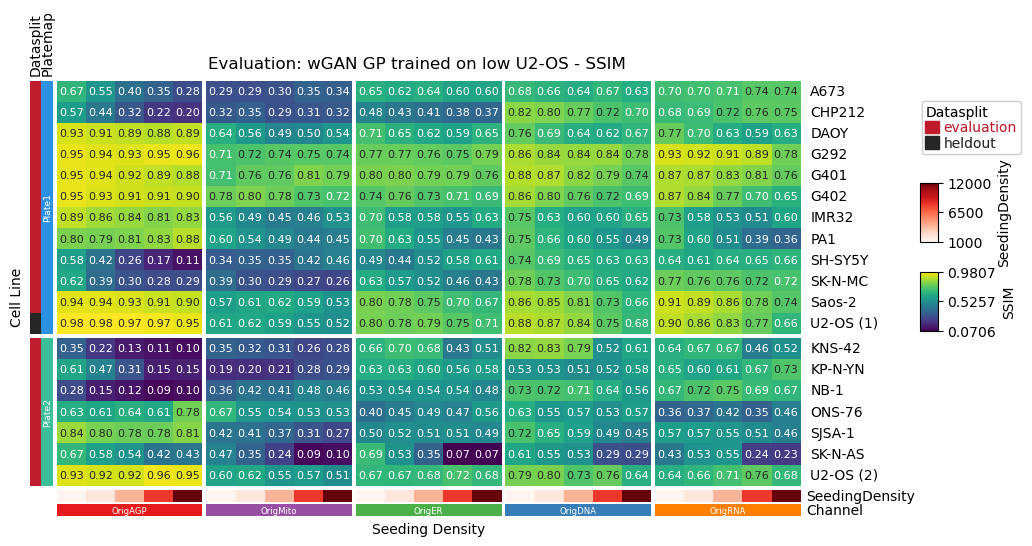

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 25.930555555555557 mm


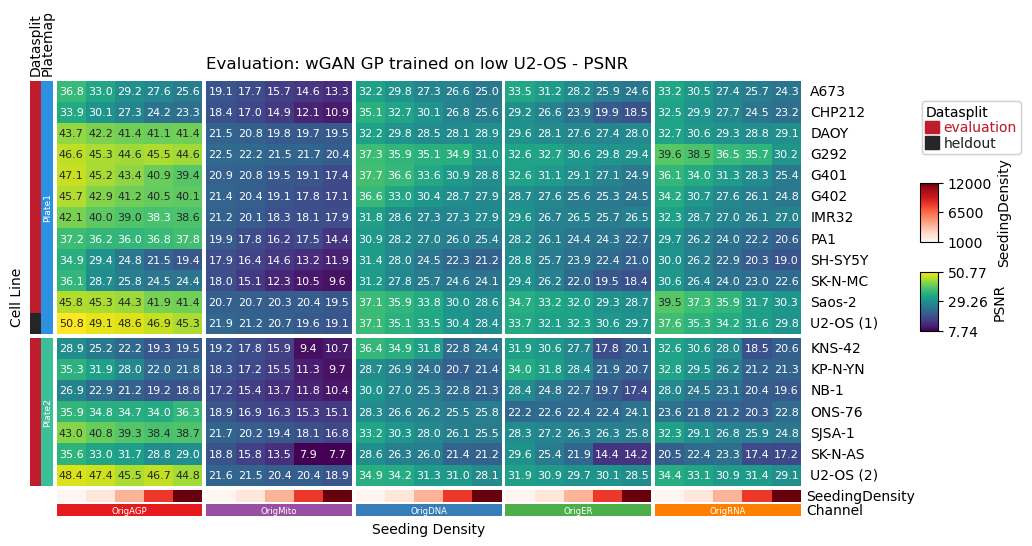

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 25.930555555555557 mm


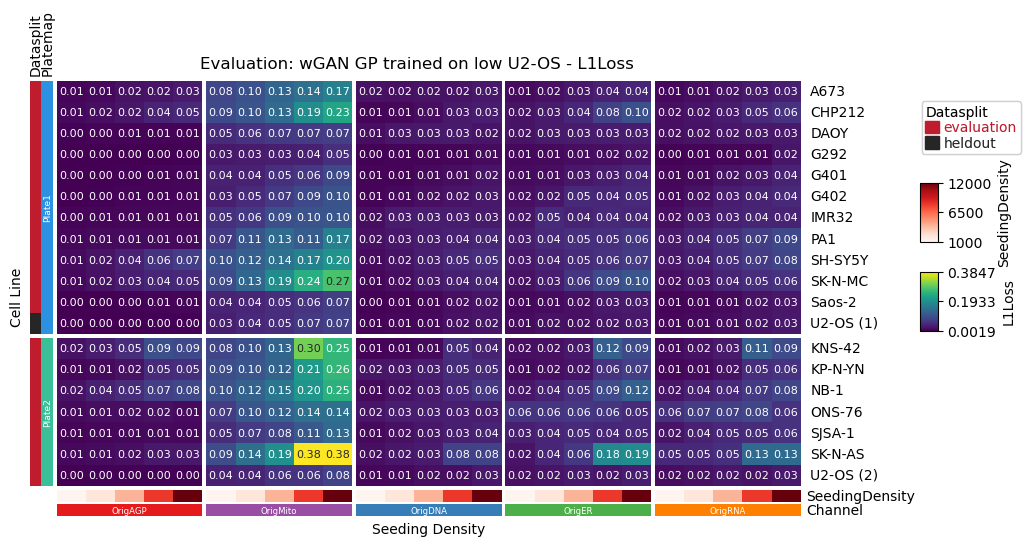

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 25.930555555555557 mm


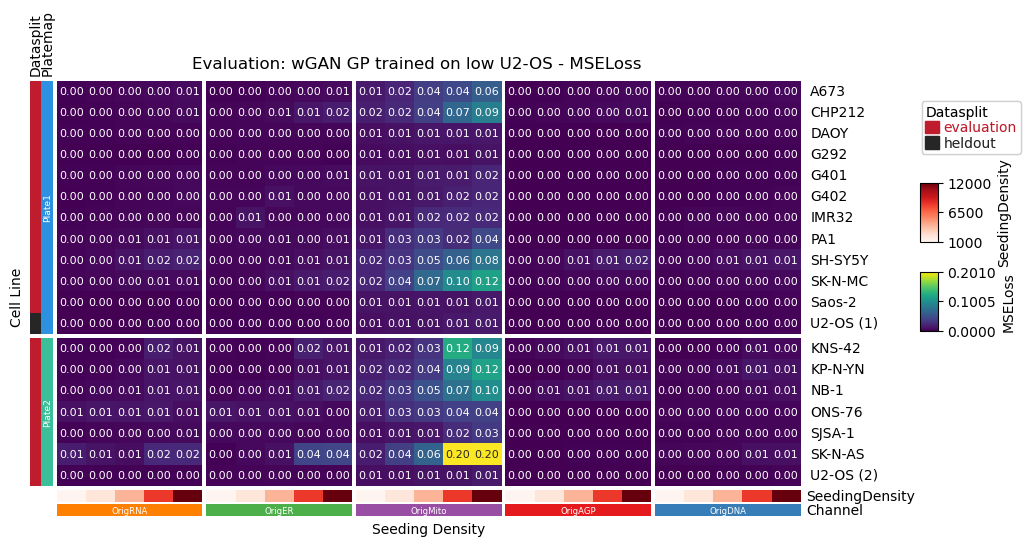

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 25.930555555555557 mm


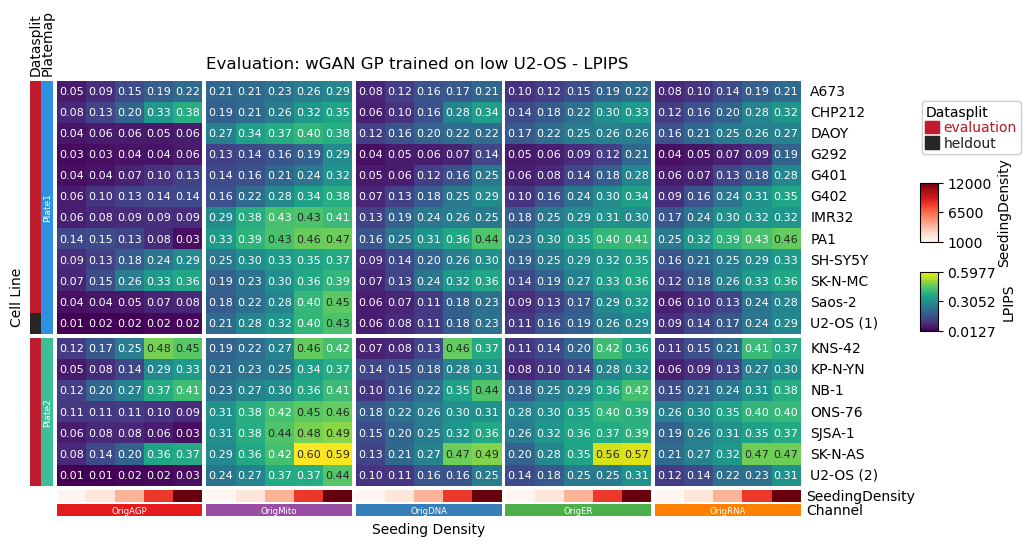

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 25.930555555555557 mm


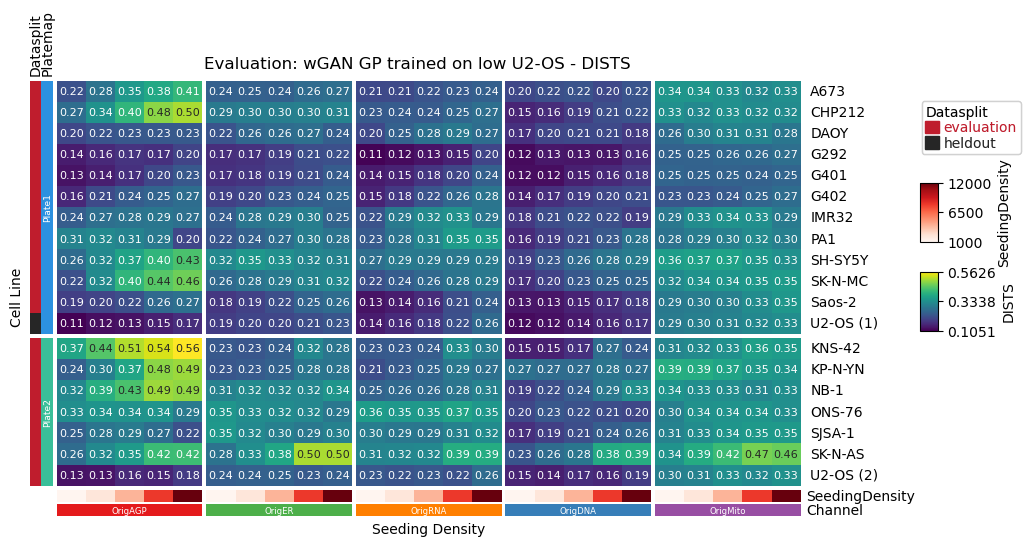

In [6]:
metric_names = ['SSIM', 'PSNR', 'L1Loss', 'MSELoss', 'LPIPS', 'DISTS']
metric_formats = {
    'SSIM': '.2f',
    'PSNR': '.1f',
    'L1Loss': '.2f',
    'MSELoss': '.2f',
    'LPIPS': '.2f',
    'DISTS': '.2f'
}
grouped_df = all_metrics_df.groupby('confluence')

for group_name, df in grouped_df:

    for metric_name in metric_names:
        pivot_df, row_annotation_df, column_annotation_df = prepare_metric_aggr_anno(df, metric_name)
        _ = plot_metric_heatmap(
            pivot_df=pivot_df,
            row_annotation_df=row_annotation_df,
            column_annotation_df=column_annotation_df,
            metric_name=metric_name,
            title=f"Evaluation: wGAN GP trained on {group_name} U2-OS - {metric_name}",
            save_path=PLOT_SAVE_DIR / f"wgan_gp_{group_name}_{metric_name}_eval_summary.png",
            sns_kwargs={'annot':True, 'fmt':metric_formats[metric_name], 'annot_kws':{'fontsize': 8}}
        )